In [1]:
import pandas as pd
import datetime
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import re
from sklearn.metrics import roc_auc_score,auc,roc_curve
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

path = "risk_predict/risk_data/"
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
from imp import reload 

In [2]:
#认证信息表(身份证号、认证时间、电话、申请贷款唯一编号)
train_auth_info = pd.read_csv(path+'auth_info.csv',parse_dates=  ['auth_time'])

#银行卡信息表(银行卡名称、卡号后四位、类型、电话、申请贷款唯一编号)
train_bankcard_info  = pd.read_csv(path+'bankcard_info.csv')

#信用卡信息 {credit_score:'网购平台信用评分',overdraft:'网购平台信用额度使用值',quota:'网购平台信用额度',id:'申请贷款唯一编号'}
train_credit_info  = pd.read_csv(path+'credit_info.csv')

#订单信息
train_order_info  = pd.read_csv(path+'order_info.csv',parse_dates=["time_order"])

#收货地址
train_recieve_addr_info  = pd.read_csv(path+'recieve_addr_info.csv')

#个人信息
train_user_info  = pd.read_csv(path+'user_info.csv')

#逾期标签
train_target  = pd.read_csv(path+'target.csv',parse_dates=['appl_sbm_tm'])


In [3]:
# 中国电信:1 中国联通:2 中国移动:3 未知：4
def phone_where(var):
    if var is np.nan:
        return '未知'
    pos = var[:3]
    if re.search('^1(3[3]|4[19]|5[3]|7[037]|8[019]|9[19])',pos):
        return '中国电信'
    if re.search('^1(3[0-2]|4[56]|5[56]|6[6]|7[156]|8[56])',pos):
        return '中国联通'
    if  re.search('^1(3[4-9]|4[7]|5[012789]|7[28]|8[23478]|9[8])',pos):
        return '中国移动'
    return '其他'

In [4]:
# 认证信息表特征 
auth_info = train_auth_info.drop_duplicates()
auth_info['auth_time_exist'] = auth_info['auth_time'].isnull().map({True: 1,False :0})
auth_info['auth_phone_exist'] = auth_info['phone'].isnull().map({True:1,False :0})
auth_info['auth_idcard_exist'] = auth_info['id_card'].isnull().map({True: 1,False :0})
auth_info['auth_na_rate'] = auth_info.isnull().sum(axis =1)/3

# auth_info['idcard_authtime_isull'] = auth_info.apply(lambda x: 1 if ((x.id_card is np.NaN ) and \
#                                                        (x.auth_time is pd.NaT)) else 0, axis=1)
# auth_info['authtime_phone_isnull'] = auth_info.apply(lambda x: 1 if ((x.phone is np.nan) and \
#                                                            (x.auth_time is np.nan)) else 0, axis=1)

#auth_info['phone'] = auth_info['phone'].fillna(0)
auth_info['auth_phone_compy'] = auth_info['phone'].map(phone_where)
auth_info['auth_year'] = auth_info['auth_time'].map(lambda x: x.year).fillna(-1).astype(int)
auth_info['auth_month'] = auth_info['auth_time'].map(lambda x: x.month).fillna(-1).astype(int)
auth_info['auth_day'] = auth_info['auth_time'].map(lambda x: x.day).fillna(-1).astype(int)
auth_info['auth_weekday'] = auth_info['auth_time'].map(lambda x: x.weekday()).fillna(-1).astype(int)
auth_info = auth_info.drop('phone',axis = 1)
#auth_info

In [5]:
#银行卡名称规范
bankname_new = pd.read_csv(path + "temp/bankname.csv",header = None)
bankname_dict = dict(zip(bankname_new[0],bankname_new[1]))
train_bankcard_info['bank_name'] = train_bankcard_info['bank_name'].map(bankname_dict)

#有些记录bank_name为空，但是其他字段信息重复(除手机外)，仅保留信息齐全的记录
bankcard_info = train_bankcard_info.sort_values(by = 'bank_name').drop_duplicates(['tail_num','card_type','id']).reset_index()

bankcard_count = bankcard_info.groupby(by=['id'],as_index = False).agg({\
                                            'bank_name':'nunique','phone':'nunique','tail_num':'count','card_type':'nunique'})
bankcard_count.rename(columns = {'bank_name':'bankname_num',
                                       'phone':'bank_phone_num',
                                       'tail_num':'bankcard_num',
                                       'card_type': 'card_type_num'
                                      },inplace = True)

bankcard_count['is_single_bankcard'] = bankcard_count['bankcard_num'].map(lambda x : 1 if x ==1 else 0 )
bankcard_count['is_6+_bankcard'] = bankcard_count['bankcard_num'].map(lambda x : 1 if x >6 else 0 )

card_type_count = pd.crosstab(bankcard_info['id'],bankcard_info['card_type']).reset_index().rename(columns = {'信用卡' : 'credit_card_num','储蓄卡':'store_card_num'})
card_type_count['have_credit_card'] = card_type_count['credit_card_num'].map(lambda x : 1 if x >0 else 0 )
bankcard_data = pd.merge(bankcard_count,card_type_count,on = 'id')
# bankcard_data

In [6]:
#网购平台信用特征 {credit_score:'网购平台信用评分',overdraft:'网购平台信用额度使用值',quota:'网购平台信用额度',id:'申请贷款唯一编号'}
#是否有信用评分
credit_info = train_credit_info.drop_duplicates()
#credit_info['credit_score'] = credit_info['credit_score'].fillna(credit_info['credit_score'].mean())
credit_info['credit_info_na_rate'] = credit_info.isnull().sum(axis = 1)/3
#credit_info['quota_na_zero'] = credit_info['quota'].map(lambda x : 1 if x > 0.0 else 0 )  # 是否有信用额度 #
credit_info['overdraft'] = credit_info['overdraft'].fillna(0)
credit_info['quota'] = credit_info['quota'].fillna(0)
credit_info['quota_na_zero'] = credit_info['quota'].map(lambda x: 1 if (x == 0 or x is np.nan) else 0)

credit_info['quota_remain'] = credit_info.apply(lambda x : x.quota - x.overdraft if x.quota>=0.0 else np.nan,axis=1)

credit_info['quota_use_rate'] = credit_info.apply(lambda x: x.overdraft / x.quota if x.quota > 0.0 else np.nan, axis=1)

#credit_info['credit_score_rank'] = credit_info['credit_score'].rank(method='first', ascending=False)

# credit_info['credit_na_rate'] = credit_info[['credit_score', 'overdraft', 'quota']].apply(lambda x: 0 if ((x.credit_score is not np.nan) \
#                                                                     and (x.overdraft is not np.nan) and (x.quota is not np.nan)) else 1, axis=1)

credit_info['credit_feat_is_zero'] = credit_info.apply(lambda x: 1 if ((x.credit_score == 0) and \
                                                                    (x.overdraft == 0) and (x.quota == 0)) else 0, axis=1)
#是否有信用评分
credit_info['credit_score_na_zero'] = credit_info['credit_score'].map(lambda x: 1 if (x == 0.0 or x is np.nan) else 0)

#是否有剩余额度
credit_info['quota_remain_is_zero'] = credit_info.apply(lambda x: 1 if (x.quota_remain == 0.0) and (x.quota > 0) else 0, axis=1)


# credit_info

In [7]:
#订单信息表特征 


order_info = train_order_info.sort_values(by = 'amt_order').drop_duplicates(['amt_order', 'time_order', 'phone', 'id', 'no_order_md5'])
order_info['order_null_rate'] = order_info.isnull().sum(axis = 1)/9
#order_info['amt_order'] = order_info.groupby(by = ['id'])['amt_order'].transform(lambda x : x.fillna(x.mean()))
#order_info['amt_order'] = order_info['amt_order'].fillna(order_info['amt_order'].mean())
order_info['time_order'] = order_info['time_order'].map(lambda x : pd.NaT if (str(x) == '0' or str(x) == 'nan')
                            else (datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S') if ':' in str(x)
                            else (datetime.datetime.utcfromtimestamp(int(str(x)[0:10])) + datetime.timedelta(hours = 8))))

order_info = order_info.groupby(by= ['id']).agg({'amt_order':[np.max,np.min,np.mean,lambda x : np.std(x)],'type_pay':'nunique',\
                                   'sts_order':'nunique','phone':'nunique','no_order_md5':'nunique',\
                                    'name_rec_md5':'nunique','order_null_rate':np.mean,'time_order':np.max}).reset_index()
#去除多级索引
order_info.columns = ['_'.join(x) for x in order_info.columns.ravel()]

order_info = order_info.rename(columns = {'id_':'id','amt_order_<lambda_0>':'amt_order_std'})
# order_info

In [8]:
#收货地址
recieve_addr_info = train_recieve_addr_info.drop_duplicates()
recieve_addr_info['addr_null_rate'] = recieve_addr_info.isnull().sum(axis = 1)/5
recieve_addr_info['prov'] = recieve_addr_info['region'].map(lambda x : x if x is np.nan else len(str(x)[0:2]))

recieve_addr_info = recieve_addr_info.groupby(by= ['id']).agg({'addr_id':'nunique','prov':'nunique','receiver_md5':'nunique',\
                                    'fix_phone':'nunique','addr_null_rate':np.mean}).reset_index()

recieve_addr_info = recieve_addr_info.rename(columns = {
   'addr_id' : 'addr_id_mun',
    'prov' : 'prov_num',
    'receiver_md5' : 'receiver_num',
    'fix_phone':'fix_phone_num'
})
# recieve_addr_info

In [9]:
#用户信息表
user_info = train_user_info.drop_duplicates()
user_info['birthday'] = user_info['birthday'].map(lambda x : '19%s' % str(x).replace('后','') if ('后' in str(x) and str(x)[0:2] != '00')\
                                    else('19%s' % str(x).replace('鍚','') if ('鍚' in str(x) and str(x)[0:2] !='00')\
                                    else ('20%s' % str(x).replace('后','') if ('后' in str(x) and str(x)[0:2] =='00')\
                                    else ('20%s' % str(x).replace('鍚','') if ('鍚' in str(x) and str(x)[0:2] =='00')\
                                    else (str(x).replace('?','-') if '?' in str(x)\
                                    else str(x))))))

user_info['birthday'] = user_info['birthday'].map(lambda x :str(x).replace('-0-','-01-') if '-0-' in str(x) else str(x))
                                                  
user_info['birthday'] = user_info['birthday'].map(lambda x :str(x) + '1' if str(x)[-2:] == '-0'else str(x))

user_info['birthday']  = user_info['birthday'].map(lambda x:datetime.datetime.strptime(\
                                                    str(x),'%Y-%m-%d') if(re.match('(19|20)\d{2}-\d{1,2}-\d{1,2}',str(x)) ) else np.nan)
user_info['user_nan_rate'] = user_info.isnull().sum(axis = 1)/11

user_info['account_grade'] = user_info['account_grade'].map({'注册会员':1,'铜牌会员':2,'银牌会员':3,'金牌会员':4,'钻石会员':5})

In [10]:
#数据集合并
df1 = pd.merge(train_target,user_info,on='id')
df2 = pd.merge(df1,recieve_addr_info,on='id')
df3 = pd.merge(df2,order_info,on='id')
df4 = pd.merge(df3,credit_info,on='id')
df5 = pd.merge(df4,bankcard_data,on='id')
all_data = pd.merge(df5,auth_info,on='id',suffixes = ('_user','_auth'))


In [11]:
# 1、对于性别为保密或为空的值，利用uer_info的id_card倒数第二位来推断性别
#2、uer_info 的id_card信息缺失92%以上(auth_info该字段缺失值30%)，所以用该字段不为空的值去填充auth_info 的空值，然后取ID_card首位数字
idx1 = all_data[(all_data['id_card_user'].notnull()) &((all_data['sex'] == '保密')| (all_data['sex'].isnull()))].index
idx2 = all_data[(all_data['id_card_user'].notnull()) & (all_data['id_card_auth'].isnull())].index
all_data.loc[idx1,'sex']= all_data.loc[idx1,'id_card_user'].map(lambda x : '女' if int(str(x)[-2:-1])%2 == 0  else '男')
all_data.loc[idx2,'id_card_auth']= all_data.loc[idx2,'id_card_user']
all_data['id_card_top1'] = all_data['id_card_auth'].map(lambda x : x if x is np.nan else x[0])
all_data['loan_hour'] = all_data['appl_sbm_tm'].map(lambda x:x.hour)
all_data['loan_day'] = all_data['appl_sbm_tm'].map(lambda x:x.day)
all_data['loan_month'] = all_data['appl_sbm_tm'].map(lambda x:x.month)
all_data['loan_year'] = all_data['appl_sbm_tm'].map(lambda x:x.year)
# 申请贷款距离认证时的间隔天数
all_data['appl_auth_day'] = all_data.apply(lambda x: (x['appl_sbm_tm'] - x['auth_time']).days,axis=1)
#最后一次消费与申请贷款时间间隔
all_data['appl_order_day'] = all_data.apply(lambda x: (x['appl_sbm_tm'] - x['time_order_amax']).days,axis=1)
# 贷款时的年龄
all_data['appl_age'] = all_data.apply(lambda x: (x['appl_sbm_tm'] - x['birthday']).days,axis=1)
all_data.to_csv('all_data.csv',index=False)

In [12]:
all_data = pd.read_csv('all_data.csv',parse_dates=['appl_sbm_tm'])
#all_data.dtypes
drop_cols = ['id','birthday', 'hobby', 'merriage','income', 'id_card_user', 'degree', 'industry','auth_time','time_order_amax','id_card_auth']
train_data = all_data.drop(drop_cols,axis = 1)
#train_data.sample(5)
feat = ['sex','qq_bound','wechat_bound','auth_phone_compy']
train_data.loc[:,feat] =train_data.loc[:,feat].fillna('未知')

import data_preprocessing
aa_list = ['account_grade', 'amt_order_amax', 'amt_order_amin', 'amt_order_mean',
       'amt_order_std', 'quota_use_rate', 'appl_auth_day','id_card_top1',
       'appl_order_day', 'appl_age']
train_data = data_preprocessing.fillna_num_var(train_data,col_list =aa_list, fill_type='class')
train_data = data_preprocessing.fillna_num_var(train_data,col_list = ['credit_score'], fill_type='median')

train_data.sample(5)

,appl_sbm_tm,target,sex,qq_bound,wechat_bound,account_grade,user_nan_rate,addr_id_mun,prov_num,receiver_num,fix_phone_num,addr_null_rate,amt_order_amax,amt_order_amin,amt_order_mean,amt_order_std,type_pay_nunique,sts_order_nunique,phone_nunique,no_order_md5_nunique,name_rec_md5_nunique,order_null_rate_mean,credit_score,overdraft,quota,credit_info_na_rate,quota_na_zero,quota_remain,quota_use_rate,credit_feat_is_zero,credit_score_na_zero,quota_remain_is_zero,bankname_num,bank_phone_num,bankcard_num,card_type_num,is_single_bankcard,is_6+_bankcard,credit_card_num,store_card_num,have_credit_card,auth_time_exist,auth_phone_exist,auth_idcard_exist,auth_na_rate,auth_phone_compy,auth_year,auth_month,auth_day,auth_weekday,id_card_top1,loan_hour,loan_day,loan_month,loan_year,appl_auth_day,appl_order_day,appl_age
5865,2017-04-07 11:31:22,0,保密,未绑定,未绑定,1.0,0.636364,1,1,0,0,1.000000,-1.0,-1.0,-1.000,-1.000000,0,0,0,0,0,1.000000,385.0,0.00,0.0,0.0,1,0.00,-1.000000,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0.000000,中国移动,2017,2,2,3,4.0,11,7,4,2017,64.0,-1.0,-1.0
97293,2017-04-14 14:46:29,0,女,未绑定,已绑定,-1.0,0.636364,2,1,1,0,0.333333,-1.0,-1.0,-1.000,-1.000000,0,0,0,0,0,1.000000,573.0,0.00,0.0,0.0,1,0.00,-1.000000,0,0,0,0,2,3,2,0,0,1,2,1,1,0,1,0.666667,中国移动,-1,-1,-1,-1,-1.0,14,14,4,2017,-1.0,-1.0,11546.0
32269,2017-04-08 17:46:36,0,男,未绑定,未绑定,3.0,0.545455,1,1,1,0,0.200000,1099.0,26.8,322.414,412.740786,1,1,1,5,1,0.244444,398.0,0.00,0.0,0.0,1,0.00,-1.000000,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0.000000,中国联通,2016,11,11,4,4.0,17,8,4,2017,148.0,198.0,10740.0
53779,2017-04-25 04:55:50,0,保密,已绑定,已绑定,4.0,0.636364,2,1,2,1,0.100000,4888.0,39.0,745.430,1184.283175,1,4,2,20,2,0.288889,392.0,515.42,5834.0,0.0,0,5318.58,0.088348,0,0,0,5,2,8,2,0,1,5,3,1,0,0,0,0.000000,中国移动,2016,3,5,5,4.0,4,25,4,2017,416.0,296.0,-1.0
39152,2016-11-15 11:50:24,0,男,未绑定,未绑定,3.0,0.545455,1,1,0,0,1.000000,-1.0,-1.0,-1.000,-1.000000,0,0,0,0,0,1.000000,403.0,0.00,0.0,1.0,1,0.00,-1.000000,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0.000000,中国移动,2016,6,9,3,3.0,11,15,11,2016,159.0,-1.0,12148.0


In [27]:
#独热编码转换
dum_data = pd.get_dummies(train_data)
print(dum_data.shape)
#dum_data.sample(5)
data_filter = data_preprocessing.const_delete(dum_data,dum_data.columns,threshold=0.9,target = 'target')

print(data_filter.shape)
data_filter.sample(5)

(120929, 68)
常变量/同值化处理的变量个数为5; ['prov_num', 'quota_remain_is_zero', 'bank_phone_num', 'is_6+_bankcard', 'sex_女']
(120929, 63)


,appl_sbm_tm,target,account_grade,user_nan_rate,addr_id_mun,receiver_num,fix_phone_num,addr_null_rate,amt_order_amax,amt_order_amin,amt_order_mean,amt_order_std,type_pay_nunique,sts_order_nunique,phone_nunique,no_order_md5_nunique,name_rec_md5_nunique,order_null_rate_mean,credit_score,overdraft,quota,credit_info_na_rate,quota_na_zero,quota_remain,quota_use_rate,credit_feat_is_zero,credit_score_na_zero,bankname_num,bankcard_num,card_type_num,is_single_bankcard,credit_card_num,store_card_num,have_credit_card,auth_time_exist,auth_phone_exist,auth_idcard_exist,auth_na_rate,auth_year,auth_month,auth_day,auth_weekday,id_card_top1,loan_hour,loan_day,loan_month,loan_year,appl_auth_day,appl_order_day,appl_age,sex_保密,sex_未知,sex_男,qq_bound_已绑定,qq_bound_未知,qq_bound_未绑定,wechat_bound_已绑定,wechat_bound_未知,wechat_bound_未绑定,auth_phone_compy_中国电信,auth_phone_compy_中国移动,auth_phone_compy_中国联通,auth_phone_compy_未知
29726,2017-04-17 11:42:17,0,2.0,0.636364,1,1,0,0.4,799.00,799.00,799.000000,0.000000,1,1,1,1,1,0.222222,509.0,0.00,0.0,0.0,1,0.00,-1.00000,0,0,0,1,1,1,0,1,0,0,0,0,0.000000,2017,9,17,6,1.0,11,17,4,2017,-153.0,145.0,-1.0,0,0,1,0,0,1,1,0,0,0,1,0,0
21810,2017-03-16 16:23:04,1,1.0,0.636364,2,2,0,0.2,-1.00,-1.00,-1.000000,-1.000000,0,0,0,0,0,1.000000,349.0,0.00,0.0,0.0,1,0.00,-1.00000,0,0,0,2,2,0,1,1,1,0,0,0,0.000000,2017,1,3,1,4.0,16,16,3,2017,72.0,-1.0,-1.0,0,0,0,1,0,0,1,0,0,0,1,0,0
58350,2017-03-08 05:14:43,0,-1.0,0.636364,2,1,0,0.3,29.94,29.94,29.940000,0.000000,1,1,1,1,1,0.222222,388.0,0.00,0.0,0.0,1,0.00,-1.00000,0,0,2,4,2,0,2,2,1,0,0,0,0.000000,2016,12,12,0,4.0,5,8,3,2017,86.0,20.0,10671.0,0,0,1,0,0,1,1,0,0,0,0,1,0
117565,2017-03-07 10:29:24,0,3.0,0.636364,1,1,0,0.2,576.00,39.00,177.944444,132.232072,1,1,1,27,1,0.238683,296.0,481.29,1500.0,0.0,0,1018.71,0.32086,0,0,0,1,1,1,0,1,0,0,0,0,0.000000,2016,12,5,0,4.0,10,7,3,2017,92.0,6.0,-1.0,1,0,0,0,0,1,0,0,1,0,1,0,0
79286,2017-01-25 10:01:57,0,-1.0,0.727273,1,0,0,1.0,-1.00,-1.00,-1.000000,-1.000000,0,0,0,0,0,1.000000,413.0,0.00,4500.0,0.0,0,4500.00,0.00000,0,0,1,3,2,0,2,1,1,1,0,1,0.666667,-1,-1,-1,-1,-1.0,10,25,1,2017,-1.0,-1.0,-1.0,0,0,1,0,0,1,0,0,1,0,1,0,0


In [28]:
import FeatureSelect
reload(FeatureSelect)
#去除共线性
vif_cols = FeatureSelect.vif(data_filter.iloc[:,2:],thres = 9.0)
data_filter = data_filter[['appl_sbm_tm','target']+vif_cols ]
data_filter.to_csv('data_filter.csv',index=False)

remain 29 features:


delete 32 features,['amt_order_amax', 'amt_order_mean', 'amt_order_std', 'overdraft', 'quota', 'quota_na_zero', 'quota_remain', 'quota_use_rate', 'credit_feat_is_zero', 'credit_score_na_zero', 'bankcard_num', 'card_type_num', 'credit_card_num', 'store_card_num', 'have_credit_card', 'auth_time_exist', 'auth_phone_exist', 'auth_idcard_exist', 'auth_na_rate', 'auth_year', 'auth_month', 'appl_auth_day', 'qq_bound_已绑定', 'qq_bound_未知', 'qq_bound_未绑定', 'wechat_bound_已绑定', 'wechat_bound_未知', 'wechat_bound_未绑定', 'auth_phone_compy_中国电信', 'auth_phone_compy_中国移动', 'auth_phone_compy_中国联通', 'auth_phone_compy_未知']


In [15]:

data = pd.read_csv('data_filter.csv',parse_dates=['appl_sbm_tm'])
#data = data_filter.copy()
# 使用贷款时间在2017-04之前的数据为训练集
data['appl_sbm_tm'] = data['appl_sbm_tm'].astype(str).map(lambda x :x[:7])

x_train = data[data['appl_sbm_tm'] <= '2017-03'].iloc[:,2:].copy().reset_index(drop = True)
y_train = data[data['appl_sbm_tm'] <= '2017-03'].loc[:,'target'].copy().reset_index(drop = True)


# 使用贷款时间在2017-04的数据为测试集
x_test = data[data['appl_sbm_tm'] == '2017-04'].iloc[:,2:].copy().reset_index(drop = True)
y_test = data[data['appl_sbm_tm'] == '2017-04'].loc[:,'target'].copy().reset_index(drop = True)

print(x_train.shape)
print(x_test.shape)

(88762, 29)
(32167, 29)


In [16]:
#时序交叉验证特征，使用xgboost10折交叉，刷选出9个重要特征
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=10)

xgb_model =xgb.XGBClassifier(max_depth=4,learning_rate=0.05,n_estimators=200,objective='binary:logistic', 
booster='gbtree', n_jobs=-1,min_child_weight=50,subsample=0.7,colsample_bytree=0.7,
reg_alpha=0,reg_lambda=1,random_state=7)


cv_cols = FeatureSelect.cross_validate_feats(xgb_model,x_train,y_train,cv=tscv,top_features = 20)
print('filter {} features:\n{}'.format(len(cv_cols),cv_cols))
x_train2 = x_train[cv_cols]
x_test2 = x_test[cv_cols]

filter 9 features:
['fix_phone_num', 'id_card_top1', 'order_null_rate_mean', 'credit_score', 'user_nan_rate', 'bankname_num', 'addr_null_rate', 'is_single_bankcard', 'account_grade']


In [17]:
lgbm_params = dict(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
            max_depth=2, n_estimators= 800,max_features = 140, objective='binary',
            subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
            learning_rate=0.05, min_child_weight=35,random_state=1,n_jobs=-1)

lgb_model = lgb.LGBMClassifier(**lgbm_params)

lgb_model.fit(x_train2,y_train)

lgb_train_pred = lgb_model.predict_proba(x_train2)[:,1]

fpr_train,tpr_train,_ = roc_curve(y_train,lgb_train_pred)
train_ks = abs(fpr_train - tpr_train).max()
train_auc = roc_auc_score(y_train,lgb_train_pred)


print('train auc',train_auc)
print('train ks',train_ks)


train auc 0.8307558583262314
train ks 0.5284840599810653


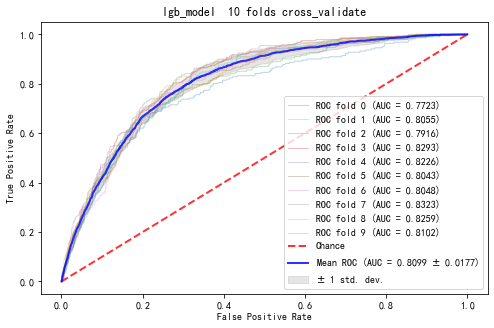

In [18]:
#验证模型稳定性
import ModelEvaluation
reload(ModelEvaluation)
tscv = TimeSeriesSplit(n_splits=10)
ModelEvaluation.plot_roc_cv(lgb_model,x_train2,y_train,cv=tscv,cv_TimeSeries = True,title = 'lgb_model')

In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import  LogisticRegression

#添加三个参数抖动模型
lgbm_params1 = dict(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
            max_depth=2, n_estimators= 800,max_features = 140, objective='binary',
            subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
            learning_rate=0.05, min_child_weight=35,random_state=1,n_jobs=-1)

lgbm_params2 = dict(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
            max_depth=2, n_estimators= 400,max_features = 140, objective='binary',
            subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
            learning_rate=0.1, min_child_weight=35,random_state=2,n_jobs=-1)


lgbm_params3 = dict(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
            max_depth=3, n_estimators= 1700,max_features = 140, objective='binary',
            subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
            learning_rate=0.01, min_child_weight=35,random_state=3,n_jobs=-1)

lgb_model1 = lgb.LGBMClassifier(**lgbm_params1)
lgb_model2 = lgb.LGBMClassifier(**lgbm_params2)
lgb_model3 = lgb.LGBMClassifier(**lgbm_params3)


lr = LogisticRegression()

#采用stacking策略LR融合
stacking_ensemble = [('lgbm1',lgb_model1),('lgbm2',lgb_model2),('lgbm3',lgb_model3)]


stacking_clf = StackingClassifier(estimators = stacking_ensemble ,final_estimator = lr,cv = 5,
                         stack_method = 'auto', n_jobs = -1)
stacking_clf.fit(x_train2,y_train)

stacking_train_pred = stacking_clf.predict_proba(x_train2)[:,1]

fpr_train,tpr_train,_ = roc_curve(y_train,stacking_train_pred)
train_ks = abs(fpr_train - tpr_train).max()
train_auc = roc_auc_score(y_train,stacking_train_pred)


print('-train auc',train_auc)
print('-train ks',train_ks)

-train auc 0.8316374447319245
-train ks 0.5282106704785643


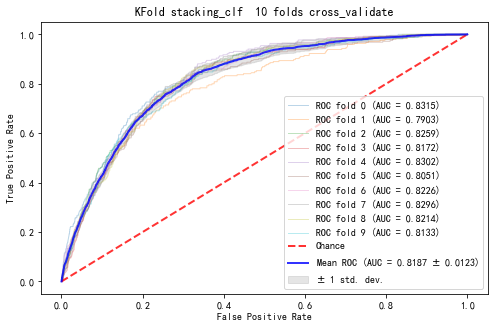

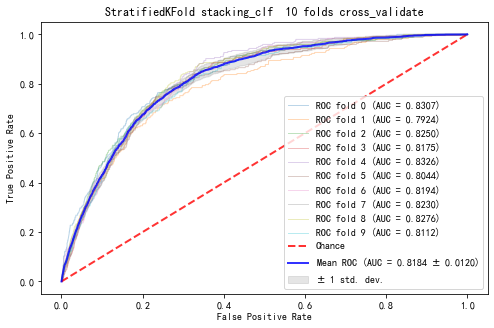

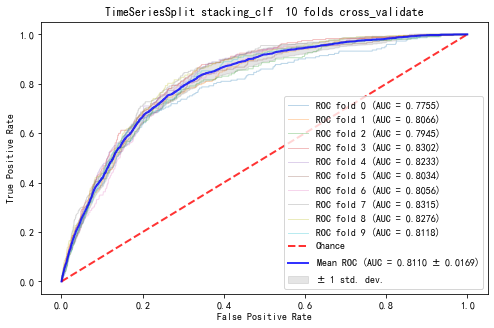

In [20]:
#融合模型后稳定性交叉检验

from sklearn.model_selection import StratifiedKFold,KFold
kf= KFold(10)
skf= StratifiedKFold(10)

#分割510折交叉验证
ModelEvaluation.plot_roc_cv(stacking_clf,x_train2,y_train,cv=kf,cv_TimeSeries = False,title = 'KFold stacking_clf')
#分层10折交叉验证
ModelEvaluation.plot_roc_cv(stacking_clf,x_train2,y_train,cv=skf,cv_TimeSeries = False,title = 'StratifiedKFold stacking_clf')

#时序分割10折交叉验证
ModelEvaluation.plot_roc_cv(stacking_clf,x_train2,y_train,cv=tscv,cv_TimeSeries = True,title = 'TimeSeriesSplit stacking_clf')



In [23]:
#对测试集预测
stacking_test_pred = stacking_clf.predict_proba(x_test2)[:,1]
fpr_test,tpr_test,_ = roc_curve(y_test,stacking_test_pred)
test_ks = abs(fpr_test - tpr_test).max()
test_auc = roc_auc_score(y_test,stacking_test_pred)

print('-test auc',test_auc)
print('-test ks',test_ks)

-test auc 0.8217440135226148
-test ks 0.5187020717143032
